In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
from pathlib import Path
from matplotlib_venn import venn2 
from upsetplot import from_contents, UpSet

wd_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_CUTandTAG/custom_pipeline'
os.chdir(wd_dir)

current_dir = os.getcwd()



CpG Island Length Statistics:
count    17017.000000
mean       655.518305
std        456.286796
min        201.000000
25%        336.000000
50%        534.000000
75%        828.000000
max       5129.000000
Name: length, dtype: float64


,chrom,start,end,name,score,strand,length
0,chr1,3531624,3531843,611,CpG:,27,219
1,chr1,3670619,3671074,613,CpG:,34,455
2,chr1,3671654,3672156,613,CpG:,45,502
3,chr1,4491701,4493673,619,CpG:,165,1972
4,chr1,4496947,4497608,619,CpG:,47,661


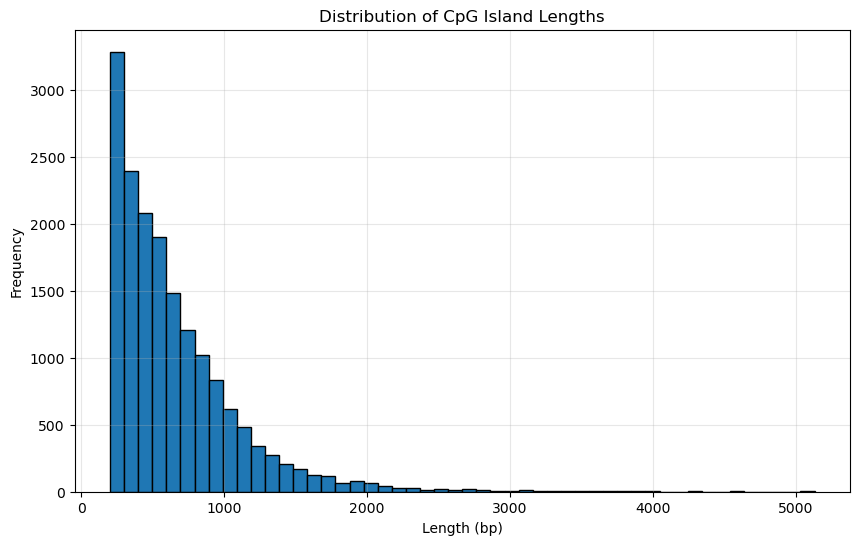

In [2]:
cpg_df = pd.read_csv("DATA/cpg_islands.bed", sep='\t', header=None, 
                     names=['chrom', 'start', 'end', 'name', 'score', 'strand'])

# Calculate lengths
cpg_df['length'] = cpg_df['end'] - cpg_df['start']

# Create histogram of CpG island lengths
plt.figure(figsize=(10,6))
plt.hist(cpg_df['length'], bins=50, edgecolor='black')
plt.title('Distribution of CpG Island Lengths')
plt.xlabel('Length (bp)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Show summary statistics
print("\nCpG Island Length Statistics:")
print(cpg_df['length'].describe())

cpg_df.head()

In [3]:
def get_peaks_with_cpg(peak_file, cpg_file, extend=300, coverage_threshold=20):
    """
    Identifies peaks that overlap with CpG islands above a coverage threshold.
    
    Args:
        peak_file: BED file containing peak regions
        cpg_file: BED file containing CpG islands
        extend: Number of base pairs to extend CpG islands (default: 100bp)
        coverage_threshold: Minimum percentage overlap required (default: 20%)
    
    Returns:
        set: Peak coordinates that meet the CpG overlap criteria
    """
    print(f"\nProcessing {peak_file}")
    
    # Validate input files
    if not all(os.path.exists(f) for f in [peak_file, cpg_file]):
        print("Error: Input file(s) missing!")
        return set()
    
    # Filter for standard chromosomes (chr1-22, X, Y)
    standard_chroms = [f"chr{i}" for i in range(1, 23)] + ['chrX', 'chrY']
    
    # Create temporary filtered files
    filtered_peaks = "temp_filtered_peaks.bed"
    filtered_cpg = "temp_filtered_cpg.bed"
    
    # Filter peaks and count
    with open(peak_file) as fin, open(filtered_peaks, 'w') as fout:
        peaks = [line for line in fin if line.split('\t')[0] in standard_chroms]
        fout.writelines(peaks)
        print(f"Peaks after chromosome filtering: {len(peaks)}")
    
    # Filter and extend CpG islands
    with open(cpg_file) as fin, open(filtered_cpg, 'w') as fout:
        fout.writelines(line for line in fin if line.split('\t')[0] in standard_chroms)
    
    # Extend CpG regions and find overlaps using bedtools
    subprocess.run(f"bedtools slop -i {filtered_cpg} -g DATA/genome.size -b {extend} > temp_extended_cpg.bed", shell=True)
    result = subprocess.run(f"bedtools intersect -a {filtered_peaks} -b temp_extended_cpg.bed -wao", 
                          shell=True, capture_output=True, text=True)
    
    # Process overlaps and calculate coverage
    peaks_with_cpg = set()
    coverage_stats = []
    current_peak = {'id': None, 'overlaps': []}
    qualified_peaks = 0
    total_peaks_with_overlap = 0
    
    for line in result.stdout.strip().split('\n'):
        fields = line.split('\t')
        peak_id = f"{fields[0]}:{fields[1]}-{fields[2]}"
        peak_length = int(fields[2]) - int(fields[1])
        
        # If we encounter a new peak
        if peak_id != current_peak['id']:
            # Process previous peak if it exists
            if current_peak['overlaps']:
                max_coverage = max(current_peak['overlaps'])
                total_peaks_with_overlap += 1
                if max_coverage >= coverage_threshold:
                    coverage_stats.append(max_coverage)
                    peaks_with_cpg.add(current_peak['id'])
                    qualified_peaks += 1
            
            current_peak = {'id': peak_id, 'overlaps': []}
            
        # Calculate overlap coverage if exists
        if fields[4] != "." and int(fields[-1]) > 0:
            coverage = (int(fields[-1]) / peak_length) * 100
            current_peak['overlaps'].append(coverage)
    
    # Process the last peak
    if current_peak['overlaps']:
        max_coverage = max(current_peak['overlaps'])
        total_peaks_with_overlap += 1
        if max_coverage >= coverage_threshold:
            coverage_stats.append(max_coverage)
            peaks_with_cpg.add(current_peak['id'])
            qualified_peaks += 1
    
    # Print coverage statistics
    if coverage_stats:
        print(f"\nPeaks with any CpG overlap: {total_peaks_with_overlap}")
        print(f"Peaks meeting {coverage_threshold}% coverage threshold: {qualified_peaks}")
        print(f"Coverage range: {min(coverage_stats):.2f}% - {max(coverage_stats):.2f}%")
        print(f"Mean coverage of qualified peaks: {sum(coverage_stats)/len(coverage_stats):.2f}%")
    
    # Cleanup temporary files
    for f in [filtered_peaks, filtered_cpg, "temp_extended_cpg.bed"]:
        if os.path.exists(f):
            os.remove(f)
    
    return peaks_with_cpg

def analyze_cpg_overlap(exo_peaks, endo_peaks, cpg_file, output_dir, extend=300, coverage_threshold=20):
    """
    Analyzes overlap between exogenous and endogenous peaks at CpG islands.
    
    Args:
        exo_peaks: BED file with exogenous peaks
        endo_peaks: BED file with endogenous peaks
        cpg_file: BED file with CpG islands
        output_dir: Output directory for results
    """
    # Get peaks overlapping CpG islands
    exo_cpg_peaks = get_peaks_with_cpg(exo_peaks, cpg_file, extend, coverage_threshold)
    endo_cpg_peaks = get_peaks_with_cpg(endo_peaks, cpg_file, extend, coverage_threshold)
    
    # Find overlapping peaks between Exo and Endo
    common_peaks = find_overlapping_peaks(exo_cpg_peaks, endo_cpg_peaks)
    
    # Get specific peaks
    exo_specific = exo_cpg_peaks - common_peaks['exo']
    endo_specific = endo_cpg_peaks - common_peaks['endo']
    
    # Create visualization
    create_venn_diagram(
        exo_specific=len(exo_specific),
        endo_specific=len(endo_specific),
        common=len(common_peaks['exo']),
        total_exo=len(exo_cpg_peaks),
        total_endo=len(endo_cpg_peaks),
        output_dir=output_dir
    )
    
    return {
        'common_exo': common_peaks['exo'],
        'common_endo': common_peaks['endo'],
        'exo_specific': exo_specific,
        'endo_specific': endo_specific
    }

def find_overlapping_peaks(exo_peaks, endo_peaks):
    """Helper function to find overlapping peaks using bedtools"""
    # Write peaks to temporary BED files
    for peaks, filename in [(exo_peaks, 'temp_exo.bed'), (endo_peaks, 'temp_endo.bed')]:
        with open(filename, 'w') as f:
            for peak in peaks:
                chrom, pos = peak.split(':')
                start, end = pos.split('-')
                f.write(f"{chrom}\t{start}\t{end}\n")
    
    # Find overlaps using bedtools
    subprocess.run("bedtools intersect -a temp_exo.bed -b temp_endo.bed -wa -wb > temp_overlaps.bed", shell=True)
    
    # Parse overlaps
    common_exo = set()
    common_endo = set()
    with open('temp_overlaps.bed') as f:
        for line in f:
            fields = line.strip().split('\t')
            common_exo.add(f"{fields[0]}:{fields[1]}-{fields[2]}")
            common_endo.add(f"{fields[3]}:{fields[4]}-{fields[5]}")
    
    # Cleanup
    for f in ['temp_exo.bed', 'temp_endo.bed', 'temp_overlaps.bed']:
        if os.path.exists(f):
            os.remove(f)
    
    return {'exo': common_exo, 'endo': common_endo}

def create_venn_diagram(exo_specific, endo_specific, common, total_exo, total_endo, output_dir):
    """Creates a Venn diagram showing peak overlaps"""
    plt.figure(figsize=(10, 10))
    venn2(subsets=(exo_specific, endo_specific, common),
          set_labels=('Exogenous', 'Endogenous'),
          set_colors=('lightblue', 'lightgreen'))
    
    plt.title(f'CpG Peak Overlap - {os.path.basename(output_dir)}')
    plt.figtext(0.1, 0.02,
                f'Exo shared: {common/total_exo*100:.1f}%\n'
                f'Endo shared: {common/total_endo*100:.1f}%',
                fontsize=10)
    
    plt.savefig(os.path.join(output_dir, "cpg_overlap_venn.pdf"),
                bbox_inches='tight', dpi=300)
    plt.close()

In [4]:
"""Main execution function"""
# Setup paths
cpg_file = "DATA/cpg_islands.bed"
output_dir = "results/cpg_analysis"
os.makedirs(output_dir, exist_ok=True)

# Analyze NSCs and Neurons
for cell_type in ['NSC', 'Neuron']:
    results = analyze_cpg_overlap(
        f"results/consensus_peaks/{cell_type}_Exo_consensus.bed",
        f"results/consensus_peaks/{cell_type}_Endo_consensus.bed",
        cpg_file,
        f"{output_dir}/{cell_type}",
        extend=300,
        coverage_threshold=20
    )


Processing results/consensus_peaks/NSC_Exo_consensus.bed
Peaks after chromosome filtering: 13473

Peaks with any CpG overlap: 4146
Peaks meeting 20% coverage threshold: 4113
Coverage range: 20.33% - 100.00%
Mean coverage of qualified peaks: 95.35%

Processing results/consensus_peaks/NSC_Endo_consensus.bed
Peaks after chromosome filtering: 23792

Peaks with any CpG overlap: 7655
Peaks meeting 20% coverage threshold: 7589
Coverage range: 20.07% - 100.00%
Mean coverage of qualified peaks: 96.02%

Processing results/consensus_peaks/Neuron_Exo_consensus.bed
Peaks after chromosome filtering: 61261

Peaks with any CpG overlap: 11847
Peaks meeting 20% coverage threshold: 11715
Coverage range: 20.00% - 100.00%
Mean coverage of qualified peaks: 97.33%

Processing results/consensus_peaks/Neuron_Endo_consensus.bed
Peaks after chromosome filtering: 26958

Peaks with any CpG overlap: 8689
Peaks meeting 20% coverage threshold: 8612
Coverage range: 20.06% - 100.00%
Mean coverage of qualified peaks: 9

# MeCP2 CpG Targeting Analysis

## Neural Progenitor Cells (NPCs/NSCs)
- Exogenous MeCP2 targets 4,145 CpG regions
- Endogenous MeCP2 targets 7,654 CpG regions 
- They share 3,697 common CpG targets (89.9% of Exo peaks, 48.6% of Endo peaks)
- This high overlap suggests that exogenous MeCP2 largely recapitulates endogenous targeting patterns

## Neurons
- Exogenous MeCP2 targets 11,846 CpG regions
- Endogenous MeCP2 targets 8,688 CpG regions
- They share 8,717 common CpG targets (74.4% of Exo peaks, 95.2% of Endo peaks)
- The very high overlap of endogenous peaks with exogenous peaks suggests even stronger concordance in neurons

## Key Observations
- Both Exo and Endo MeCP2 show very high coverage of their CpG targets (>94% mean coverage in all cases)
- The targeting is highly specific, as indicated by the high mean coverage percentages 
- The overlap is particularly strong in neurons, where almost all endogenous targets (95.2%) are also bound by exogenous MeCP2

In [5]:
"""Main execution function"""
# Setup paths
cpg_file = "DATA/cpg_islands.bed"
output_dir = "results/cpg_analysis"
os.makedirs(output_dir, exist_ok=True)

# Analyze NSCs and Neurons
for cell_type in ['NSC', 'Neuron']:
    results = analyze_cpg_overlap(
        f"results/consensus_peaks/{cell_type}_Exo_consensus.bed",
        f"results/consensus_peaks/{cell_type}_Endo_consensus.bed",
        cpg_file,
        f"{output_dir}/{cell_type}",
        extend=300,
        coverage_threshold=70
    )


Processing results/consensus_peaks/NSC_Exo_consensus.bed
Peaks after chromosome filtering: 13473

Peaks with any CpG overlap: 4146
Peaks meeting 70% coverage threshold: 3878
Coverage range: 70.13% - 100.00%
Mean coverage of qualified peaks: 97.95%

Processing results/consensus_peaks/NSC_Endo_consensus.bed
Peaks after chromosome filtering: 23792

Peaks with any CpG overlap: 7655
Peaks meeting 70% coverage threshold: 7210
Coverage range: 70.02% - 100.00%
Mean coverage of qualified peaks: 98.39%

Processing results/consensus_peaks/Neuron_Exo_consensus.bed
Peaks after chromosome filtering: 61261

Peaks with any CpG overlap: 11847
Peaks meeting 70% coverage threshold: 11276
Coverage range: 70.08% - 100.00%
Mean coverage of qualified peaks: 99.23%

Processing results/consensus_peaks/Neuron_Endo_consensus.bed
Peaks after chromosome filtering: 26958

Peaks with any CpG overlap: 8689
Peaks meeting 70% coverage threshold: 8204
Coverage range: 70.00% - 100.00%
Mean coverage of qualified peaks: 9